## DuneAI segmentation in XNAT

In [1]:
# First, run the following command from terminal: 
# /workspace/admin/envs/duneai/etc/activate.d/init.sh
# then select 'duneai' kernel from available kernels. Restart notebook if not listed.

### 1. Configure data

In [1]:
import os, subprocess, sys
#local imports
pymipl_path = os.path.abspath(os.path.join('../../','pymipl'))
sys.path.append(pymipl_path)
from dicom_sort import *
from pathlib import Path

project='RIDER-LUNG-CT'
path=f'/data/projects/{project}/experiments'
d=analyze_dir(path)


/data/projects/RIDER-LUNG-CT/experiments/09-20-2006-1-NA-96508
/data/projects/RIDER-LUNG-CT/experiments/09-20-2006-1-NA-96508_SEG


### 2. Detect structural CT scans in data.

In [2]:
from pathlib import Path
ct_scans=[]
for exp in d['children']:
    #print (Path(exp['path']).stem)
    exp_label=Path(exp['path']).stem
    for subdir1 in exp['children']:        
        if Path(subdir1['path']).stem == 'SCANS': 
            #print(subdir1['path'])
            for scan in subdir1['children']:
                scan_label=Path(scan['path']).stem
                #print (scan_label)
                try:
                    #print(scan['children'][0]['children'][0]['SOPClass'])
                    if scan['children'][0]['children'][0]['SOPClass']=='CTImageStorage':
                        #print('CT image:', scan_label)
                        ct_scans+=[scan['children'][0]['children'][0]]
                except Exception as e:
                    pass
                    
print(ct_scans)
                    

[{'PatName': 'RIDER-1129164940', 'SeriesDescription': None, 'SOPClass': 'CTImageStorage', 'SeriesInstanceUID': '1.3.6.1.4.1.9328.50.1.48441840081578419409180519840073808100', 'path': '09-20-2006-1-NA-96508/SCANS/8/DICOM/1-187.dcm', 'level': 5}, {'PatName': 'RIDER-1129164940', 'SeriesDescription': None, 'SOPClass': 'CTImageStorage', 'SeriesInstanceUID': '1.3.6.1.4.1.9328.50.1.83304264089411327530730818890072724533', 'path': '09-20-2006-1-NA-96508/SCANS/4/DICOM/1-187.dcm', 'level': 5}]


### 3. Create batch file.

In [28]:
import datetime
root_dir=Path("/workspace/admin")
outdir=root_dir / project
pymipl_dir=root_dir / "pymipl"
duneai_dir=root_dir / "DuneAI/AutomaticSegmentationScript"

dt=datetime.datetime.now().strftime("%Y%m%d_%H%M")
batch_file=outdir / f"batch_{dt}.sh"
print(batch_file)
! echo "#!/bin/bash" > {batch_file}
for scan in ct_scans:
    dcm_path=(Path(path) / scan['path']).parent
    scan_id=Path(scan['path']).parent.parent.stem
    exp_label=Path(scan['path']).parent.parent.parent.parent.stem
    #print(exp_label)
    subject=scan['PatName']
    out_path=outdir / f"{subject}/{exp_label}/{scan_id}/ct"
    #!echo "outdir: {out_path}"
    out_path.parent.mkdir(parents=True,exist_ok=True)
    #create nifti
    print (f"python {(pymipl_dir / 'test_rt-utils.py')} {dcm_path} {out_path}")
    if not Path(out_path.as_posix()+'_struct.nii').exists():
        ! echo "python {(pymipl_dir / 'test_rt-utils.py')} {dcm_path} {out_path}" >> {batch_file}
    ! echo "python {(duneai_dir / 'segmentation-cl.py')} {out_path}_struct.nii {out_path.parent} {out_path.parent}" >> {batch_file}

! chmod +x {batch_file}
    


/workspace/admin/RIDER-LUNG-CT/batch_20251117_2024.sh
python /workspace/admin/pymipl/test_rt-utils.py /data/projects/RIDER-LUNG-CT/experiments/09-20-2006-1-NA-96508/SCANS/8/DICOM /workspace/admin/RIDER-LUNG-CT/RIDER-1129164940/09-20-2006-1-NA-96508/8/ct
python /workspace/admin/pymipl/test_rt-utils.py /data/projects/RIDER-LUNG-CT/experiments/09-20-2006-1-NA-96508/SCANS/4/DICOM /workspace/admin/RIDER-LUNG-CT/RIDER-1129164940/09-20-2006-1-NA-96508/4/ct


In [25]:
out_path+"_struct.nii"

TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

In [3]:
###################################################################
## Import DL packages setting up GPU if used
import os
import tensorflow as tf
import keras.backend as K
from TheDuneAI import ContourPilot as cp 

#If you have an available GPU and tensorflow-gpu >=1.15.0, CUDA >= 10.0.130, CuDNN installed you can try setting gpu=True
GPU_compute = True
if GPU_compute:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
    os.environ['CUDA_VISIBLE_DEVICES']='0'          #Choose GPU device ID
    #Check availableGPUs
    #print(K.tensorflow_backend._get_available_gpus())
    print(tf.config.list_physical_devices('GPU'))
    
    

2025-11-07 15:00:38.609156: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 15:00:38.612672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-07 15:00:38.661704: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-07 15:00:38.662968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-07 15:00:41.759919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

[]


2025-11-07 15:00:53.867985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-07 15:00:53.880893: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
###################################################################
##Initialize model inputs
model_path=r'./model_files/'   #path to the model files

path_to_test_data = r'../Software for qualitative assesment/test_data'  #path to the data to be segmented (nrrds)

save_path ='/home/mmilchenko/src/DuneAI/Automatic segmentation script/segmentations'

#r'./produced segmentations' #path for the output files (nrrds)

#initialize the model
model = cp(model_path,path_to_test_data,save_path,verbosity=True)    #set verbosity =True to see what is going on


100%|██████████| 3/3 [00:00<00:00, 1243.00it/s]

3  Patients found
Epoch end
------- Loading patients in predict mode -------


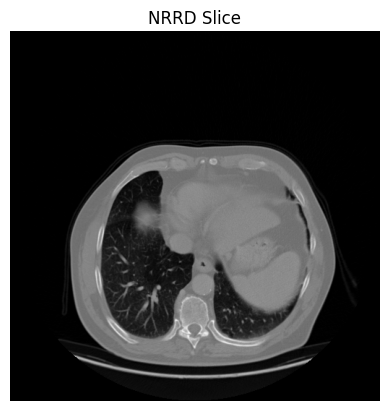

In [3]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Read and convert to numpy
image = sitk.ReadImage(path_to_test_data+'/pat1/image.nrrd')
array = sitk.GetArrayFromImage(image)

# Show a slice
plt.imshow(array[array.shape[0] // 2], cmap='gray')
plt.title("NRRD Slice")
plt.axis('off')
plt.show()

In [4]:
###################################################################
## Estimated segmentation time per patient:
##      with GPU(RTX2080TI): 2-3 sec
##      with CPU(Core i5-7200U ): 170 -180 sec
## Estimated processing time per patient depends on the multiple parameters such as: CPU/GPU usage, Hardware (HDD/SSD),
## and length of the CT scan (whole body scan CT/ thorax CT) 
## The estimated processing time per pat. range is: 25 sec - 280 sec.
###################################################################
##Starting the segmentation process

model.segment()



Progress:   0%|          | 0/3 [00:00<?, ?it/s]

(178, 512, 512)
Window limits  -1000 150.0
Amount of unique values, original img:  1151 resampled img:  46
Segmentation started
1/1 [==============================] - 2s 2s/step
Segmentation is finished
time spent: 100.36932158470154 sec.


Progress:  33%|███▎      | 1/3 [02:06<04:12, 126.04s/it]

(178, 512, 512)
Window limits  -1000 150.0
Amount of unique values, original img:  1151 resampled img:  46
Segmentation started
1/1 [==============================] - 1s 1s/step
Segmentation is finished
time spent: 108.36791110038757 sec.


Progress:  67%|██████▋   | 2/3 [04:20<02:10, 130.75s/it]

(178, 512, 512)
Window limits  -1000 150.0
Amount of unique values, original img:  1151 resampled img:  46
Segmentation started
1/1 [==============================] - 2s 2s/step
Segmentation is finished
time spent: 97.17095232009888 sec.


Progress: 100%|██████████| 3/3 [06:23<00:00, 127.95s/it]


In [20]:
model.Output_path

'/home/mmilchenko/src/DuneAI/Automatic segmentation script/segmentations'

In [ ]:
os.path.exists(os.path.join(model.Output_path,filename.split('\\')[-2]+'_(DL)'))